## COVID19 Forecasting Project

**ECE 685:** Deep Learning <br>
**Students:** Guillem Amat, Sebastián Soriano Pérez

### Setup

#### Loading Packages

In [1]:
'''Loading packages and additional setup'''
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import pdb
import csv
import os
import warnings
from countrygroups import EUROPEAN_UNION
from us import states
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from pylab import rcParams

# Hides warnings
warnings.filterwarnings("ignore")

# Increases resolution of Jupyter Notebooks on Macs
%config InlineBackend.figure_format = 'retina'

In [2]:
'''Loading PyTorch and specific functions'''
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

<br>

#### Loading Data

In [3]:
'''Loading COVID cases and fatalities data'''
#%cd Desktop
#PATH = r'C:\Users\guill\Desktop\Final Project'
#os.chdir(PATH)
#data = pd.read_csv(os.path.join(os.getcwd(), 'Data', 'week_5', 'train.csv'))
data = pd.read_csv('../Data/week_5/train.csv')

<br>

**Data preprocessing**

In [4]:
'''Creating "location" column'''
data['County']         = data['County'].fillna('')
data['Province_State'] = data['Province_State'].fillna('')

data['location'] = data['Country_Region'] + ' ' + data['Province_State'] + ' ' + data['County']
data.head()

,Id,County,Province_State,Country_Region,Population,Weight,Date,Target,TargetValue,location
0,1,,,Afghanistan,27657145,0.058359,2020-01-23,ConfirmedCases,0,Afghanistan
1,2,,,Afghanistan,27657145,0.583587,2020-01-23,Fatalities,0,Afghanistan
2,3,,,Afghanistan,27657145,0.058359,2020-01-24,ConfirmedCases,0,Afghanistan
3,4,,,Afghanistan,27657145,0.583587,2020-01-24,Fatalities,0,Afghanistan
4,5,,,Afghanistan,27657145,0.058359,2020-01-25,ConfirmedCases,0,Afghanistan


In [5]:
'''Creating "population" dataset'''
population = data[['location', 'Population']].drop_duplicates()
population.head()

,location,Population
0,Afghanistan,27657145
280,Albania,2886026
560,Algeria,40400000
840,Andorra,78014
1120,Angola,25868000


In [6]:
'''Loading geographical coordinates for every country'''
#coordinates = pd.read_csv(os.path.join(os.getcwd(), 'Data', 'other', 'coordinates.csv'))
coordinates = pd.read_csv('../Data/other/coordinates.csv')
coordinates.head()

,Location,Longitude,Latitude
0,Afghanistan,66.238514,33.768006
1,Albania,19.999962,41.000028
2,Algeria,2.999983,28.000027
3,Andorra,1.573203,42.540717
4,Angola,17.569124,-11.877577


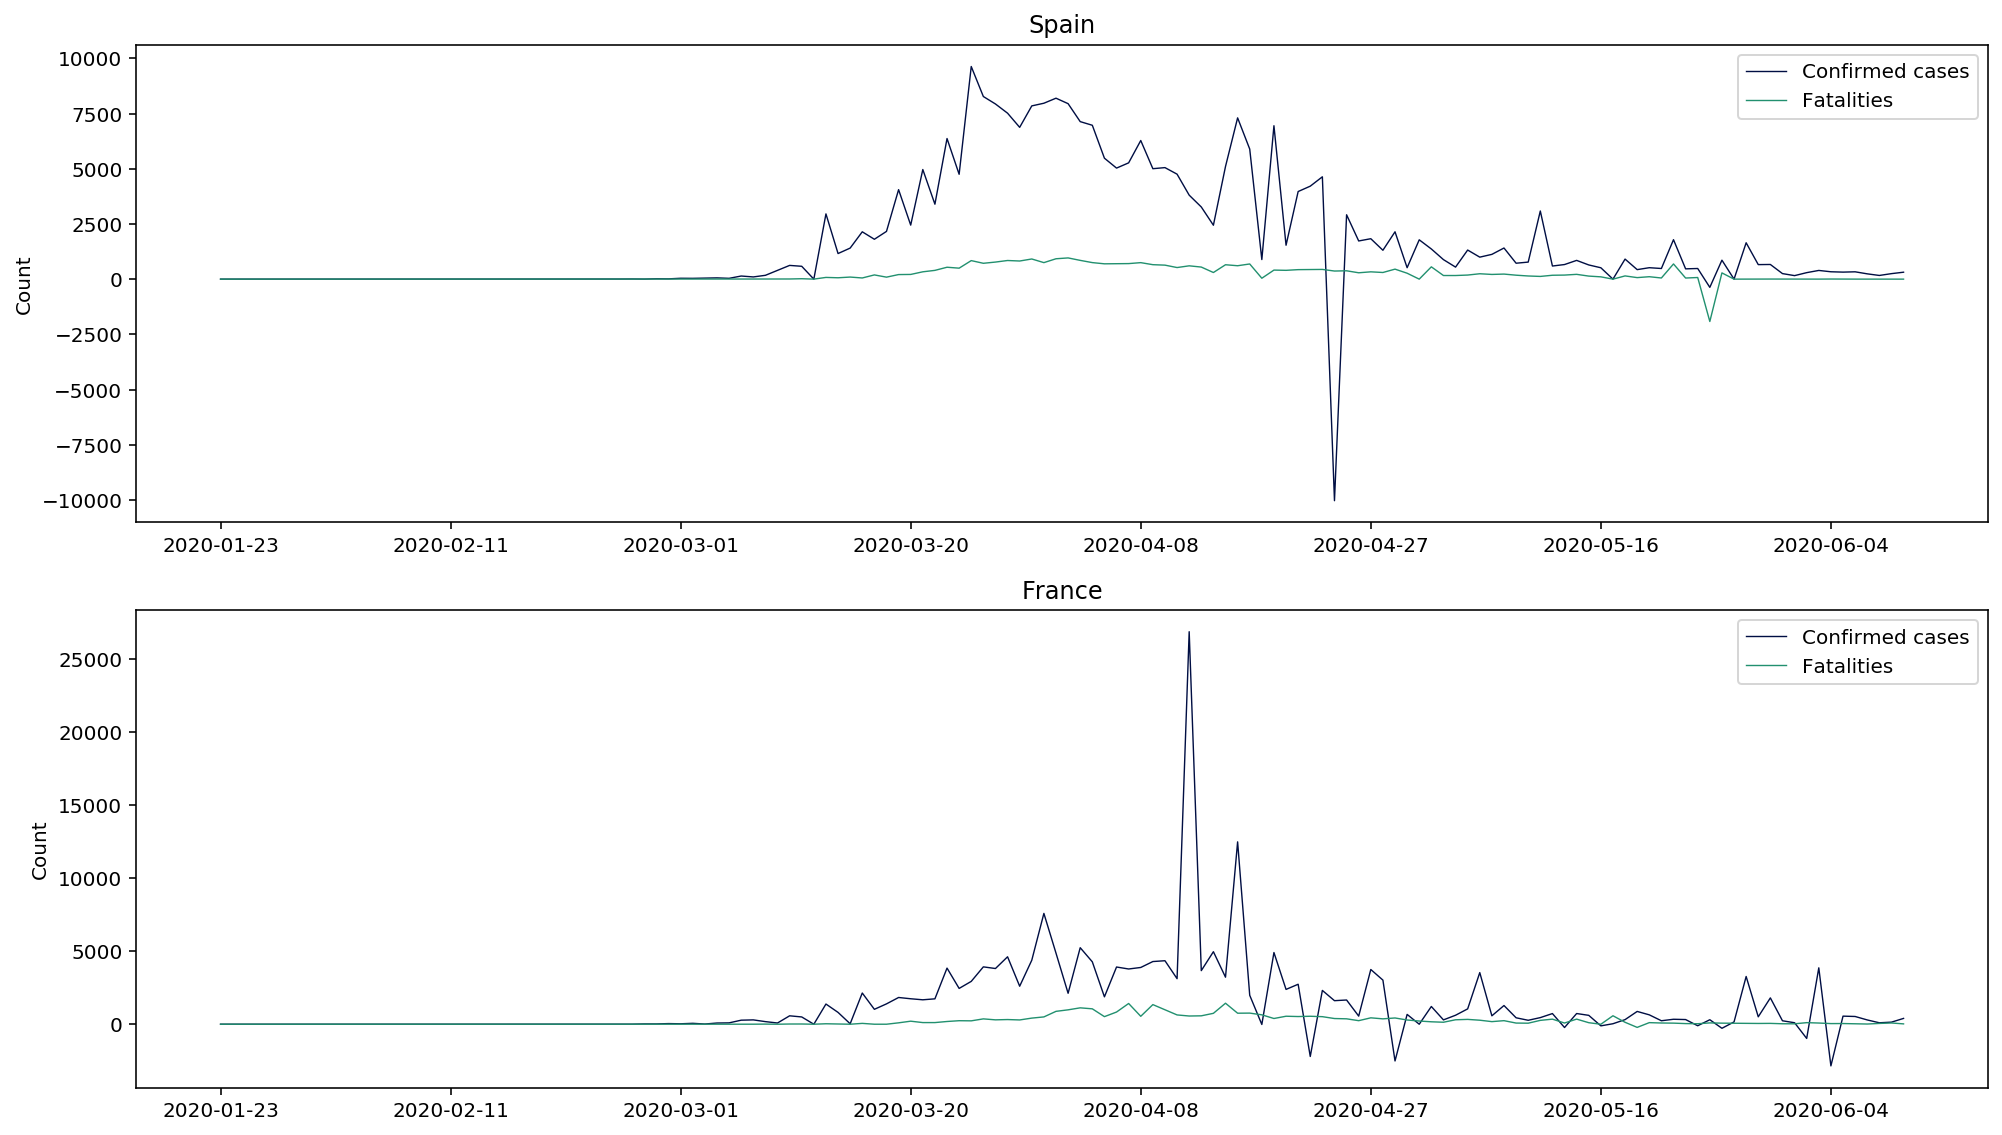

In [7]:
'''Plotting sample countries'''
rcParams['figure.figsize'] = 14, 8
plt.figure()

plt.subplot(2, 1, 1)

plt.title('Spain')
#plt.xlabel('Date')
plt.ylabel('Count')
plt.plot(
    data[(data['location'] == 'Spain  ') & (data['Target'] == 'ConfirmedCases')]['Date'], 
    data[(data['location'] == 'Spain  ') & (data['Target'] == 'ConfirmedCases')]['TargetValue'], 
    color='#000E43', linewidth=0.7, label='Confirmed cases'
)
plt.plot(
    data[(data['location'] == 'Spain  ') & (data['Target'] == 'Fatalities')]['Date'], 
    data[(data['location'] == 'Spain  ') & (data['Target'] == 'Fatalities')]['TargetValue'], 
    color='#22906F', linewidth=0.7, label='Fatalities'
)
plt.xticks(range(0, 141, 19), rotation=0)
plt.legend()
plt.tight_layout()

plt.subplot(2, 1, 2)

plt.title('France')
#plt.xlabel('Date')
plt.ylabel('Count')
plt.plot(
    data[(data['location'] == 'France  ') & (data['Target'] == 'ConfirmedCases')]['Date'], 
    data[(data['location'] == 'France  ') & (data['Target'] == 'ConfirmedCases')]['TargetValue'], 
    color='#000E43', linewidth=0.7, label='Confirmed cases'
)
plt.plot(
    data[(data['location'] == 'France  ') & (data['Target'] == 'Fatalities')]['Date'], 
    data[(data['location'] == 'France  ') & (data['Target'] == 'Fatalities')]['TargetValue'], 
    color='#22906F', linewidth=0.7, label='Fatalities'
)
plt.xticks(range(0, 141, 19), rotation=0)
plt.legend()
plt.tight_layout()

<br>

**Creating regional dataset**

In [8]:
'''Creating a "countries" dataset to model after specific locations'''
#european = EUROPEAN_UNION.names
european = ['Spain', 'Germany', 'France', 'Italy', 'United Kingdom']
american = [str(state) for state in states.STATES]

# Operations to subset for european countries
data_europe = data[data['Country_Region'].isin(european)]
data_europe = data_europe.loc[lambda x: x.Province_State == '']
data_europe = pd.pivot_table(
    data_europe, index=['location', 'Date'], columns='Target', values='TargetValue'
).reset_index()
data_europe.head()

Target,location,Date,ConfirmedCases,Fatalities
0,France,2020-01-23,0,0
1,France,2020-01-24,2,0
2,France,2020-01-25,1,0
3,France,2020-01-26,0,0
4,France,2020-01-27,0,0


In [9]:
'''Adding geographical coordinates and population to the regional dataset'''
data_europe = data_europe.merge(coordinates, how='inner', left_on='location', right_on='Location')
data_europe = data_europe.merge(population, how='left', left_on='location', right_on='location')
data_europe = data_europe.drop(['Location', 'location', 'Date'], axis=1)
data_europe.head()

,ConfirmedCases,Fatalities,Longitude,Latitude,Population
0,0,0,1.888333,46.603354,66710000
1,2,0,1.888333,46.603354,66710000
2,1,0,1.888333,46.603354,66710000
3,0,0,1.888333,46.603354,66710000
4,0,0,1.888333,46.603354,66710000


In [10]:
'''Rescaling variables'''
scaler = MinMaxScaler()
scaler = scaler.fit(data_europe)
result = scaler.transform(data_europe)

# How to transform data back to their original values
result_inv = scaler.inverse_transform(result)

In [11]:
'''Creating NumPy array'''
dataset = result.reshape(-1, 140, 5)
train   = dataset[:, :95, :]
test    = dataset[:, 95:, :]
dataset.shape, train.shape, test.shape

((5, 140, 5), (5, 95, 5), (5, 45, 5))

In [12]:
def create_sequences(data, seq_length, n_features=2):
    '''Function to create sequences from time series data'''
    X = np.zeros((data.shape[0], data.shape[1] - seq_length - 1, seq_length, data.shape[2]))
    Y = np.zeros((data.shape[0], data.shape[1] - seq_length - 1, n_features))
    
    for batch in range(X.shape[0]):
        
        xs = []; ys = []
        country = data[batch]
        
        for i in range(len(country) - seq_length - 1):
            x = data[batch][i:(i + seq_length)]
            y = data[batch][i + seq_length]
            xs.append(x)
            ys.append(y)
            
        #pdb.set_trace()
        X[batch, :, :, :] = np.array(xs)
        Y[batch, :,  :]   = np.array(ys)[:, :2]
        
    return X, Y

In [13]:
'''Creating sequences'''
seq_length = 25
X_train, y_train = create_sequences(train, seq_length=seq_length, n_features=2)
X_test,  y_test  = create_sequences(test, seq_length=seq_length, n_features=2)

In [14]:
'''Creating PyTorch dataloaders'''
X_train, y_train = torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float()
X_test, y_test   = torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()

trainset = torch.utils.data.TensorDataset(X_train, y_train)
testset  = torch.utils.data.TensorDataset(X_test, y_test)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True)
testloader  = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)

<br>

### Modeling

**Setup**

In [15]:
'''Additional setup for models'''
torch.set_default_tensor_type(torch.FloatTensor)
countries = {'France':0, 'Germany':1, 'Italy':2, 'Spain':3, 'United Kingdom': 4}

def path_model(model):
    '''Function to create paths for models'''
    #PATH1 = os.path.join(os.getcwd(), 'Models', f'{model}_model')
    PATH1 = f'../Models/{model}_model'
    #PATH2 = os.path.join(os.getcwd(), 'Models', f'{model}_state_dictionary')
    PATH2 = f'../Models/{model}_state_dictionary'
    return PATH1, PATH2

In [37]:
def train_model(model: torch.nn.Module, train: torch.utils.data.DataLoader, test: torch.utils.data.DataLoader, epochs: int, net):
    '''Function to train models'''
    #Initializing Variables to store information
    min_loss   = float('inf')
    train_loss = 0
    test_loss  = 0
    train_history = []
    test_history  = []
    
    for epoch in range(epochs):
        
        train_loss = 0
        test_loss  = 0
    
        model.train()
        for _, data in enumerate(train):
        
            if net != 'CNN': model.reset_hidden_state()
            optimizer.zero_grad()
            
            X_train, y_train = data
            X_train, y_train = Variable(torch.squeeze(X_train)), Variable(torch.squeeze(y_train))
            #if net == 'CNN': X_train = X_train.transpose(1, 2)
            y_hat = model(X_train)
            
            loss  = criterion(y_hat, y_train)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() 
            
        train_history.append(train_loss)
        
        model.eval()
        for _, data in enumerate(test):
            
            X_test, y_test = data
            X_test, y_test = torch.squeeze(X_test), torch.squeeze(y_test)
            #if net == 'CNN': X_test = X_test.transpose(1, 2)
            y_hat = model(X_test)
            
            test_loss += criterion(y_hat, y_test).item() 
       
        test_history.append(test_loss)
        
        train_loss     = str(train_loss/len(train.dataset))[:4]
        test_loss      = test_loss/len(test.dataset)
        
        if test_loss < min_loss:
            min_test_loss = test_loss
            
            #Save Model
            path1, path2 = path_model(net)
            torch.save(model, path1)
            torch.save(model.state_dict(), path2)
        
        if epoch == 0:
            string = f'''| Epoch: {epoch + 1}   | Train Loss: {train_loss} | Test Loss: {str(test_loss)[:4]} |'''
            print('-'*len(string)); print(string); print('-'*len(string))
    
        elif ((epoch + 1) % 50 == 0) & (epoch < 100):
            string = f'''| Epoch: {epoch + 1}  | Train Loss: {train_loss} | Test Loss: {str(test_loss)[:4]} |'''
            print(string); print('-'*len(string))
            
        elif ((epoch + 1) % 50 == 0) & (epoch >= 99):
            string = f'''| Epoch: {epoch + 1} | Train Loss: {train_loss} | Test Loss: {str(test_loss)[:4]} |'''
            print(string); print('-'*len(string))
        
    return model.eval(), train_history, test_history

<br>

#### Artificial Neural Network

<br>

#### Convolutional Neural Network

In [38]:
class CNN(nn.Module):
    '''CNN model'''
    def __init__(self, n_features=5, seq_len=25, n_output=2):
        super().__init__()
        self.n_features = n_features
        self.seq_len    = seq_len
        
        self.conv1d = nn.Conv1d(in_channels=n_features, out_channels=64, kernel_size=1, bias=True) #in: 25, out: 25
        self.fc1    = nn.Linear(in_features=64 * seq_len, out_features=50, bias=True)
        self.relu   = nn.ReLU(inplace=True)
        self.fc2    = nn.Linear(in_features=50, out_features=n_output)
        
    def forward(self,x):
        x = x.transpose(1, 2)
        x = self.conv1d(x)
        x = x.view(-1, 64 * self.seq_len)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x

In [39]:
'''Setting up model'''
criterion = torch.nn.MSELoss(reduction='sum')
model     = CNN(n_features=5, seq_len=25, n_output=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00025)

In [40]:
'''Training model'''
cnn, train_history, test_history = train_model(model, trainloader, testloader, 1000, net='CNN')

---------------------------------------------------
| Epoch: 1   | Train Loss: 9.92 | Test Loss: 0.80 |
---------------------------------------------------
| Epoch: 50  | Train Loss: 0.43 | Test Loss: 0.13 |
---------------------------------------------------
| Epoch: 100  | Train Loss: 0.34 | Test Loss: 0.11 |
----------------------------------------------------
| Epoch: 150 | Train Loss: 0.64 | Test Loss: 0.13 |
---------------------------------------------------
| Epoch: 200 | Train Loss: 0.27 | Test Loss: 0.10 |
---------------------------------------------------
| Epoch: 250 | Train Loss: 0.27 | Test Loss: 0.10 |
---------------------------------------------------
| Epoch: 300 | Train Loss: 0.25 | Test Loss: 0.11 |
---------------------------------------------------
| Epoch: 350 | Train Loss: 0.27 | Test Loss: 0.11 |
---------------------------------------------------
| Epoch: 400 | Train Loss: 0.24 | Test Loss: 0.11 |
---------------------------------------------------
| Epoch: 4

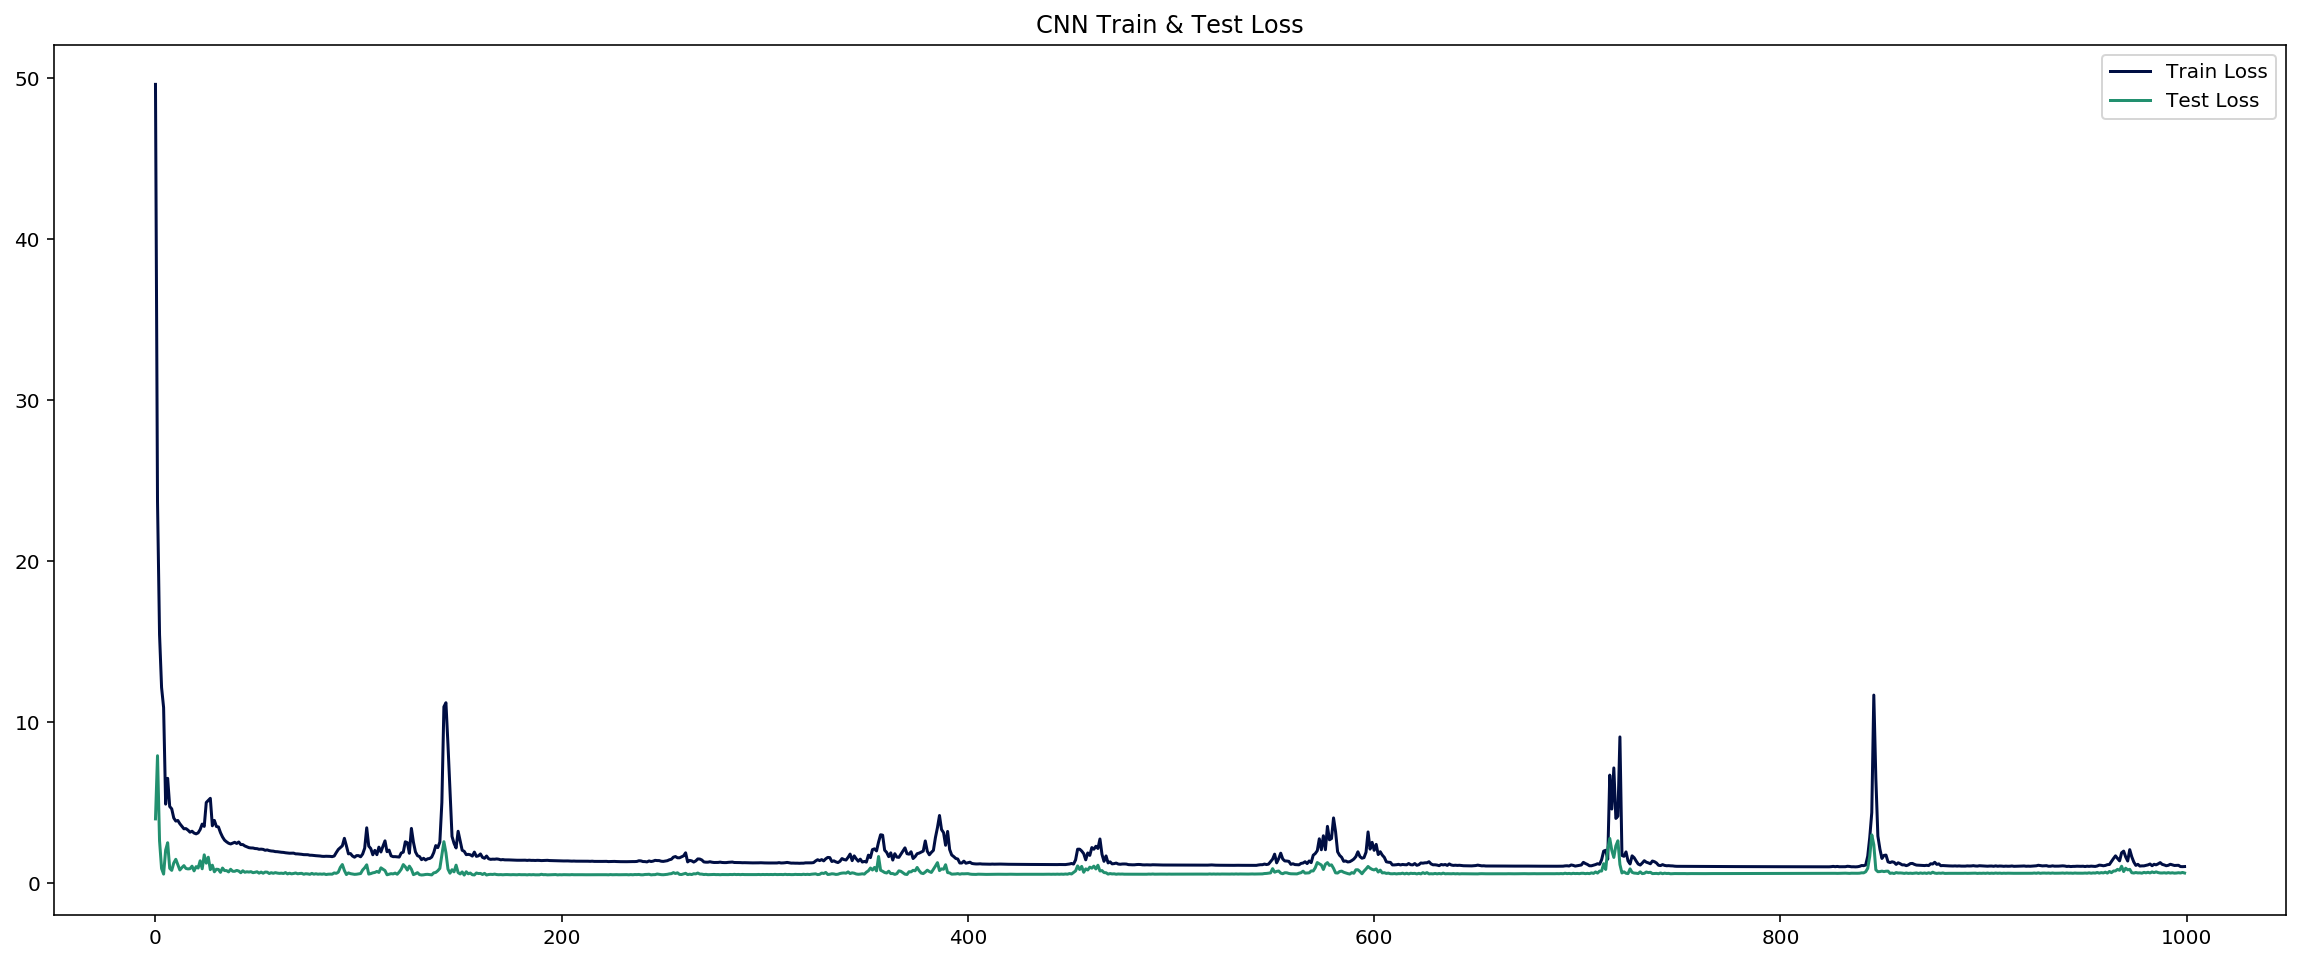

In [41]:
'''Plotting train and test loss'''
plt.figure(figsize=(20, 8))

plt.title('CNN Train & Test Loss')
plt.plot(train_history, color='#000E43', label = 'Train Loss')
plt.plot(test_history, color='#22906F', label = 'Test Loss')
plt.legend()

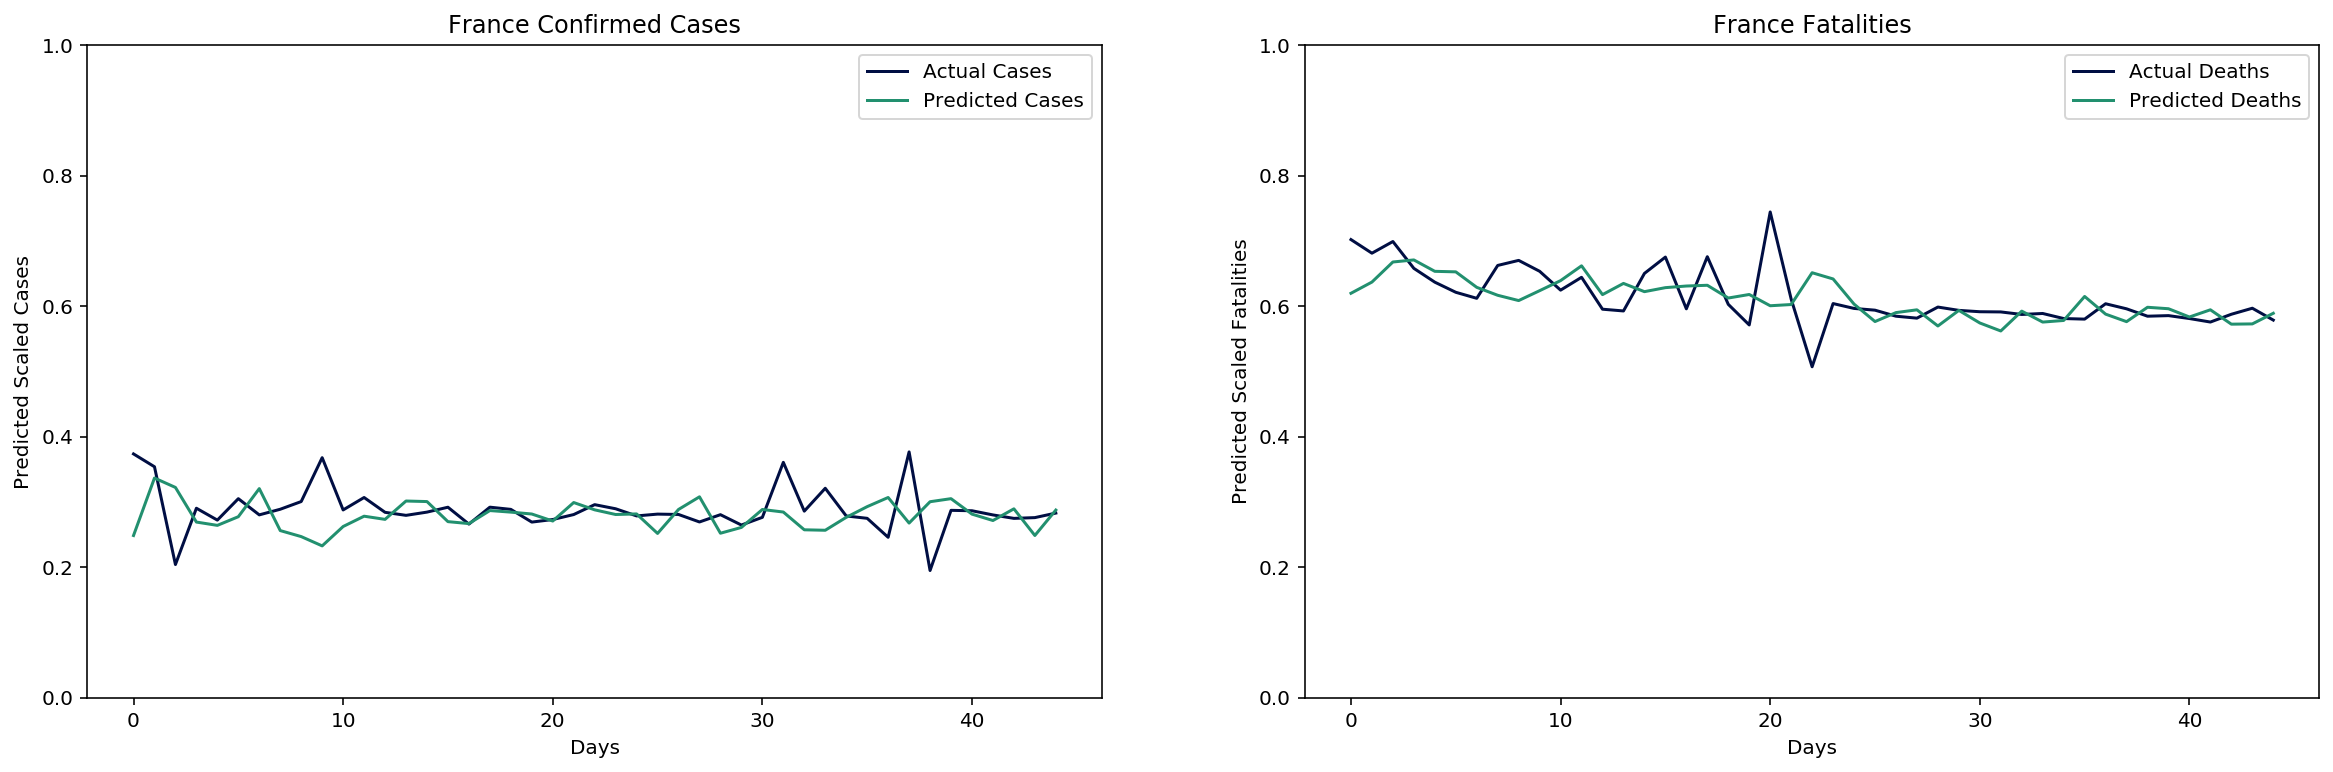

In [46]:
'''Plotting predictions for sample country'''
country_name = 'France' 
country      = countries[country_name]

#Actual Values
dset, _ = create_sequences(dataset, seq_length=25)
dset = torch.from_numpy(dset).float()

#Predictions
final = dset[country, -45:, :]
predictions = cnn(final)

fig, axes = plt.subplots(ncols=2, figsize=(20, 6))

# Confirmed Cases
axes[0].plot(dataset[country][-45:, 0], color='#000E43', label = 'Actual Cases')
axes[0].plot(predictions[:, 0].detach().numpy(), color='#22906F', label='Predicted Cases')
axes[0].set_ylim((0, 1))
axes[0].set_title(f'{country_name} Confirmed Cases')
axes[0].set_xlabel('Days')
axes[0].set_ylabel('Predicted Scaled Cases')
axes[0].legend()

# Fatalities
axes[1].plot(dataset[country][-45:, 1], color='#000E43', label = 'Actual Deaths')
axes[1].plot(predictions[:, 1].detach().numpy(), color='#22906F', label='Predicted Deaths')
axes[1].set_ylim((0, 1))
axes[1].set_title(f'{country_name} Fatalities')
axes[1].set_xlabel('Days')
axes[1].set_ylabel('Predicted Scaled Fatalities')
axes[1].legend()

<br>

#### Recurrent Neural Network

torch.Size([28, 69, 25, 5])

<br>

#### Gated Recurrent Unit

In [59]:
class GRU(nn.Module):
    def __init__(self, n_input, n_hidden, n_output, seq_len, n_layers=2):
        super().__init__()
        #pdb.set_trace()
        self.n_hidden   = n_hidden
        self.seq_len    = seq_len
        self.n_layers   = n_layers
        
        self.gru = nn.GRU(n_input, n_hidden, n_layers, dropout=0.01)
        self.fc  = nn.Linear(n_hidden, n_output)
        
    def forward(self, x):
        #pdb.set_trace()
        gru_out, self.hidden = self.gru(x.view(len(x), self.seq_len, -1), self.hidden)
        last_time_step = gru_out.reshape(self.seq_len, len(x), self.n_hidden)[-1]
        out    = self.fc(last_time_step)
        return out
    
    def reset_hidden_state(self):
        self.hidden = torch.zeros(self.n_layers, self.seq_len, self.n_hidden)

In [60]:
criterion = torch.nn.MSELoss(reduction='sum')
model     = GRU(n_input=5, n_hidden=512, seq_len=25, n_output=2, n_layers=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00025)

In [61]:
gru, train_history, test_history = train_model(model, trainloader, testloader, 500, net='GRU')

---------------------------------------------------
| Epoch: 1   | Train Loss: 23.8 | Test Loss: 0.67 |
---------------------------------------------------
| Epoch: 50  | Train Loss: 0.95 | Test Loss: 0.08 |
---------------------------------------------------
| Epoch: 100  | Train Loss: 0.98 | Test Loss: 0.07 |
----------------------------------------------------
| Epoch: 150 | Train Loss: 0.95 | Test Loss: 0.10 |
---------------------------------------------------
| Epoch: 200 | Train Loss: 0.95 | Test Loss: 0.08 |
---------------------------------------------------
| Epoch: 250 | Train Loss: 0.96 | Test Loss: 0.09 |
---------------------------------------------------
| Epoch: 300 | Train Loss: 0.94 | Test Loss: 0.10 |
---------------------------------------------------
| Epoch: 350 | Train Loss: 0.93 | Test Loss: 0.09 |
---------------------------------------------------
| Epoch: 400 | Train Loss: 0.91 | Test Loss: 0.12 |
---------------------------------------------------
| Epoch: 4

(0, 125)

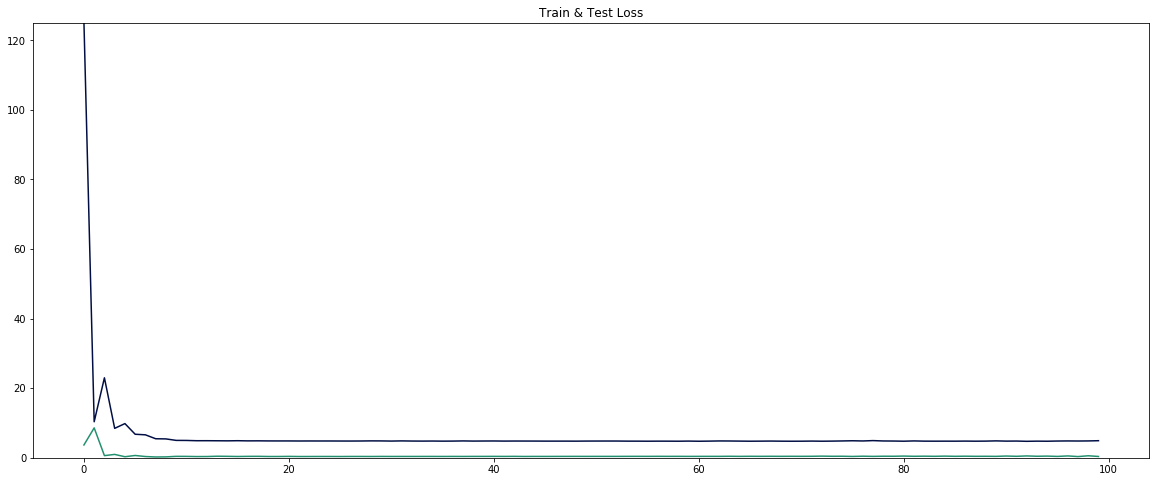

In [271]:
plt.figure(figsize=(20, 8))

plt.title('Train & Test Loss')
plt.plot(train_history, color='#000E43', label = 'Confirmed Cases')
plt.plot(test_history, color='#22906F', label = 'Fatalities')
plt.ylim((0, 125))

In [79]:
gru = torch.load(os.path.join(os.getcwd(), 'Models', 'GRU_model'))

In [86]:
country_name = 'Spain' 
country      = countries[country_name]

#Actual Values
dset, _ = create_sequences(dataset, seq_length=25)
dset = torch.from_numpy(dset).float()

#Predictions
final = dset[country, -45:, :]
predictions = gru(final)

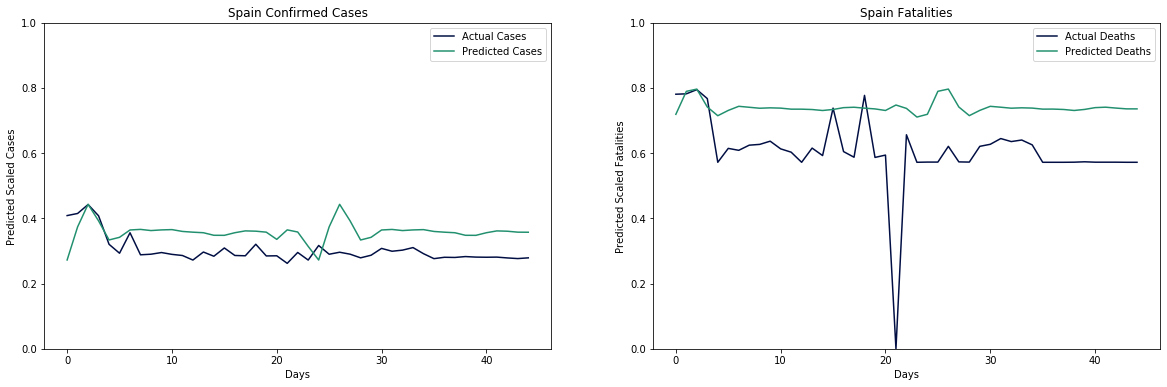

In [87]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 6))

# Confirmed Cases
axes[0].plot(dataset[country][-45:, 0], color='#000E43', label = 'Actual Cases')
axes[0].plot(predictions[:, 0].detach().numpy(), color='#22906F', label='Predicted Cases')
axes[0].set_ylim((0, 1))
axes[0].set_title(f'{country_name} Confirmed Cases')
axes[0].set_xlabel('Days')
axes[0].set_ylabel('Predicted Scaled Cases')
axes[0].legend()

# Fatalities
axes[1].plot(dataset[country][-45:, 1], color='#000E43', label = 'Actual Deaths')
axes[1].plot(predictions[:, 1].detach().numpy(), color='#22906F', label='Predicted Deaths')
axes[1].set_ylim((0, 1))
axes[1].set_title(f'{country_name} Fatalities')
axes[1].set_xlabel('Days')
axes[1].set_ylabel('Predicted Scaled Fatalities')
axes[1].legend()

<br>

#### Long-Short Term Memory

In [89]:
class LSTM(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers):
        super().__init__()
        self.n_hidden = n_hidden
        self.seq_len  = seq_len
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(input_size=n_features,
                            hidden_size=n_hidden,
                            num_layers=n_layers,
                            dropout=0.01)
        
        self.linear = nn.Linear(in_features=n_hidden, out_features=2)
     
    def reset_hidden_state(self):
        self.hidden = (torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
                       torch.zeros(self.n_layers, self.seq_len, self.n_hidden))
            
    def forward(self, sequences):
        #pdb.set_trace()
        lstm_out, self.hidden = self.lstm(sequences.view(len(sequences), self.seq_len, -1),
                                          self.hidden)
            
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        out = self.linear(last_time_step)
        return out  

In [331]:
criterion = torch.nn.MSELoss(reduction='sum')
model     = LSTM(n_features=5, n_hidden=512, seq_len=25, n_layers=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00125)

In [332]:
lstm, train_history, test_history = train_model(model, trainloader, testloader, 2500, net = 'LSTM')

---------------------------------------------------
| Epoch: 1   | Train Loss: 165. | Test Loss: 1.23 |
---------------------------------------------------
| Epoch: 200 | Train Loss: 0.94 | Test Loss: 0.11 |
---------------------------------------------------
| Epoch: 300 | Train Loss: 0.94 | Test Loss: 0.11 |
---------------------------------------------------
| Epoch: 400 | Train Loss: 0.94 | Test Loss: 0.12 |
---------------------------------------------------
| Epoch: 500 | Train Loss: 0.93 | Test Loss: 0.13 |
---------------------------------------------------
| Epoch: 600 | Train Loss: 0.93 | Test Loss: 0.13 |
---------------------------------------------------
| Epoch: 700 | Train Loss: 0.92 | Test Loss: 0.14 |
---------------------------------------------------
| Epoch: 800 | Train Loss: 0.90 | Test Loss: 0.16 |
---------------------------------------------------
| Epoch: 900 | Train Loss: 0.91 | Test Loss: 0.11 |
---------------------------------------------------
| Epoch: 100

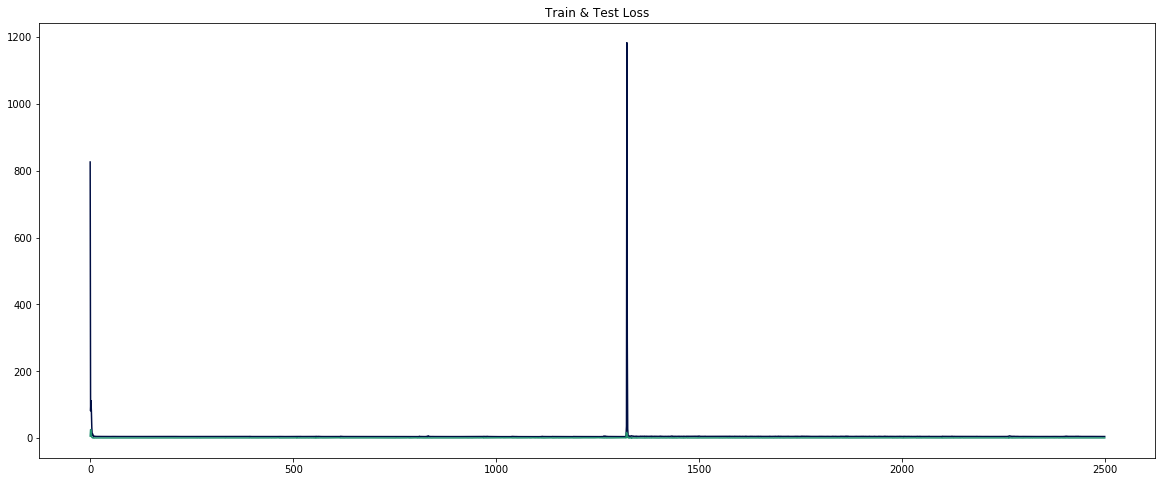

In [347]:
plt.figure(figsize=(20, 8))

plt.title('Train & Test Loss')
plt.plot(train_history, color='#000E43', label = 'Train Data')
plt.plot(test_history, color='#22906F', label = 'Test Data')
#plt.ylim((0, 125))

In [90]:
lstm = torch.load(os.path.join(os.getcwd(), 'Models', 'LSTM_model'))

In [95]:
country_name = 'Germany' 
country      = countries[country_name]

#Actual Values
dset, _ = create_sequences(dataset, seq_length=25)
dset = torch.from_numpy(dset).float()

#Predictions
final = dset[country, -45:, :]
predictions = lstm(final)

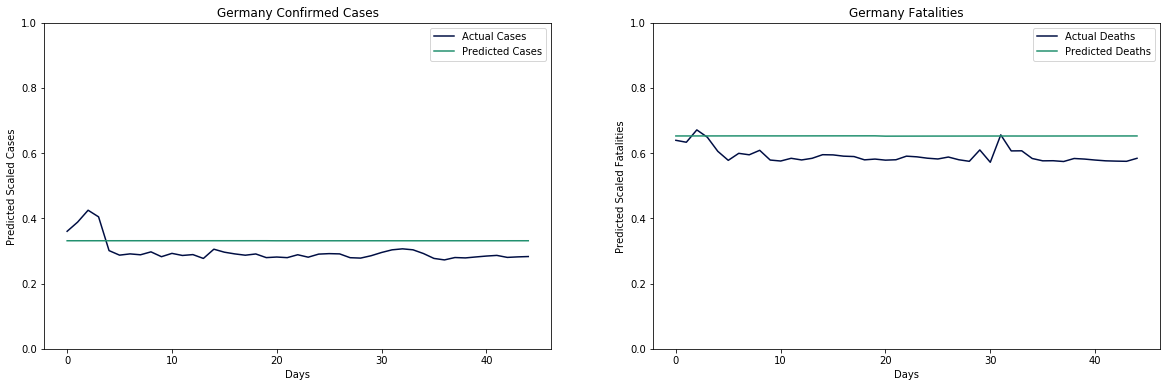

In [96]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 6))

# Confirmed Cases
axes[0].plot(dataset[country][-45:, 0], color='#000E43', label = 'Actual Cases')
axes[0].plot(predictions[:, 0].detach().numpy(), color='#22906F', label='Predicted Cases')
axes[0].set_ylim((0, 1))
axes[0].set_title(f'{country_name} Confirmed Cases')
axes[0].set_xlabel('Days')
axes[0].set_ylabel('Predicted Scaled Cases')
axes[0].legend()

# Fatalities
axes[1].plot(dataset[country][-45:, 1], color='#000E43', label = 'Actual Deaths')
axes[1].plot(predictions[:, 1].detach().numpy(), color='#22906F', label='Predicted Deaths')
axes[1].set_ylim((0, 1))
axes[1].set_title(f'{country_name} Fatalities')
axes[1].set_xlabel('Days')
axes[1].set_ylabel('Predicted Scaled Fatalities')
axes[1].legend()

<br>